# Implémentation et expérimentation de l'algorithme de construction d'arbres monotones

In [150]:
import numpy as np
import pandas as pd
import math
import random
from arbres import *
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline

### Création de la base jouet :

In [151]:
training_set = LabeledSet(2)

for i in range(0, 3):
    training_set.addExample([random.randint(0,2),random.randint(0,10)],1)
for i in range(0, 3):
    training_set.addExample([random.randint(3, 5), random.randint(0, 10)], 2)
for i in range(0, 4):
    training_set.addExample([random.randint(6, 10), random.randint(0,10)], 3)

In [152]:
df = pd.DataFrame(training_set.x, columns=['x1', 'x2'])
df['label'] = training_set.y
df

,x1,x2,label
0,2,7,1
1,1,3,1
2,2,5,1
3,3,1,2
4,4,6,2
5,5,3,2
6,9,6,3
7,9,1,3
8,6,9,3
9,6,8,3


### Ensembles dominants générés par un attribut/label

In [153]:
def dominant_sets_attribute(a_j, labeled_set):    
    '''
        a_j : index of attribute in labeled_set
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by a_j  
    '''
    values = labeled_set.x.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    for i in range(0, labeled_set.size()):
        v = labeled_set.getX(i)[a_j]
        dominant_sets[i] = set(values[values[:,a_j] >= v][:,labeled_set.getInputDimension()])
                
    return dominant_sets

def dominant_sets_label(labeled_set):
    '''
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by its label  
    '''
    values = labeled_set.y.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    
    for i in range(0, labeled_set.size()):
        v = labeled_set.getY(i)
        dominant_sets[i] = set(values[values[:,0] >= v][:,1])
                
    return dominant_sets
    
dsa_1 = dominant_sets_attribute(0, training_set)
dsa_2 = dominant_sets_attribute(1, training_set)
dsl = dominant_sets_label(training_set)

TypeError: 'LabeledSet' object is not callable

In [ ]:
df_dsa1 = pd.DataFrame(list(dsa_1.items())).drop(0, axis=1)
df_dsa1.columns = ['dominant set generated by first attribute']
df_dsa1

In [ ]:
df_dsa2 = pd.DataFrame(list(dsa_2.items())).drop(0, axis=1)
df_dsa2.columns = ['dominant set generated by second attribute']
df_dsa2

In [ ]:
df_dsl = pd.DataFrame(list(dsl.items())).drop(0, axis=1)
df_dsl.columns = ['dominant set generated by label']
df_dsl

### Construction hiérarchique de mesures de discrimination

#### f-layer :

In [ ]:
class F_layer:
    '''
        object-wise local monotonicity measure 
    '''
    def __init__(self, a_j):
        '''
            a_j : index of attribute in labeled_set
        '''
        self.a_j = a_j
        
    def value(self, w_i):
        raise NotImplementedError
        
    def equal_sets_attribute(self, labeled_set):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its equal set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[self.a_j]
            dominant_sets[i] = set(values[values[:,self.a_j] == v][:,labeled_set.getInputDimension()])

        return dominant_sets
    
    def equal_sets_label(self, labeled_set):    
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = set(values[values[:,0] == v][:,1])

        return dominant_sets
    
    def dominant_sets_attribute(self, labeled_set):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[self.a_j]
            dominant_sets[i] = set(values[values[:,self.a_j] >= v][:,labeled_set.getInputDimension()])

        return dominant_sets

    def dominant_sets_label(self, labeled_set):
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = set(values[values[:,0] >= v][:,1])

        return dominant_sets

In [ ]:
class Ds(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return ds value of w_i, a_j
        '''
        esa_i = esa[w_i]
        esl_i = esl[w_i]
        intersection = esa_i.intersection(esl_i)
        
        return len(intersection) * 1.0 / len(esa_i)

In [ ]:
ds_2 = Ds(1)
ds_2_values = []
esa = ds_2.equal_sets_attribute(training_set)
esl = ds_2.equal_sets_label(training_set)
for i in range(0, 10):
    ds_2_values.append(ds_2.value(i, training_set, esa, esl))
pd.DataFrame(ds_2_values, columns=['ds generated by second attribute'])

$dsr(\omega_i)$ :

In [ ]:
class Dsr(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return dsr value of w_i, a_j
        '''
        dsa_i = dsa[w_i]
        dsl_i = dsl[w_i]
        intersection = dsa_i.intersection(dsl_i)
        
        return len(intersection) * 1.0 / len(dsa_i)

In [ ]:
dsr_1 = Dsr(0)
dsr_1_values = []
dsa = dsr_1.dominant_sets_attribute(training_set)
dsl = dsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_1_values.append(dsr_1.value(i, training_set, dsa, dsl))
pd.DataFrame(dsr_1_values, columns=['dsr generated by first attribute'])

In [ ]:
dsr_2 = Dsr(1)
dsr_2_values = []
dsa = dsr_2.dominant_sets_attribute(training_set)
dsl = dsr_2.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_2_values.append(dsr_2.value(i, training_set, dsa, dsl))
pd.DataFrame(dsr_2_values, columns=['dsr generated by second attribute'])

In [ ]:
class Minds(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return minds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []
        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
    
        return min(intersections_lengths) * 1.0 / len(equal_set)    

In [ ]:
minds_2 = Minds(1)
minds_2_values = []
esa = minds_2.equal_sets_attribute(training_set)
esl = minds_2.equal_sets_label(training_set)

for i in range(0, 10):
    minds_2_values.append(minds_2.value(i,training_set, esa, esl))
pd.DataFrame(minds_2_values, columns=['minds generated by second attribute'])

$mindsr(\omega_i)$

In [ ]:
class Mindsr(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return mindsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []
        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
    
        return min(intersections_lengths) * 1.0 / len(dominant_set)    

In [ ]:
mindsr_1 = Mindsr(0)
mindsr_1_values = []
dsa = mindsr_1.dominant_sets_attribute(training_set)
dsl = mindsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    mindsr_1_values.append(mindsr_1.value(i,training_set, dsa, dsl))
pd.DataFrame(mindsr_1_values, columns=['mindsr generated by first attribute'])

$maxdsr(\omega_i)$

In [ ]:
class Maxdsr(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            w_i : index of object in labeled_set
            return maxdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
    
    
        return max(intersections_lengths) * 1.0 / len(dominant_set)    

In [ ]:
class Maxds(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            w_i : index of object in labeled_set
            return maxds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
    
    
        return max(intersections_lengths) * 1.0 / len(equal_set)    

$avgdsr(\omega_i)$

In [ ]:
class Avgdsr(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
            
        return (1.0/len(dominant_set) * np.sum(intersections_lengths)) * 1.0 / len(dominant_set)    

In [ ]:
class Avgds(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
            
        return (1.0/len(equal_set) * np.sum(intersections_lengths)) * 1.0 / len(equal_set)    

In [ ]:
avgdsr_2 = Avgdsr(1)
avgdsr_2_values = []
dsa = avgdsr_2.dominant_sets_attribute(training_set)
dsl = avgdsr_2.dominant_sets_label(training_set)


for i in range(0, 10):
    avgdsr_2_values.append(avgdsr_2.value(i, training_set, dsa, dsl))
pd.DataFrame(avgdsr_2_values, columns=['avgdsr generated by second attribute'])

In [ ]:
avgds_2 = Avgds(1)
avgds_2_values = []

esa = avgds_2.equal_sets_attribute(training_set)
esl = avgds_2.equal_sets_label(training_set)

for i in range(0, 10):
    avgds_2_values.append(avgds_2.value(i, training_set, esa, esl))
pd.DataFrame(avgds_2_values, columns=['avgds generated by second attribute'])

#### g-layer :

In [ ]:
class G_layer:
    '''
        object-wise local non-monotonicity measure
    '''
        
    def value(self, f_value):
        raise NotImplementedError

In [ ]:
class Log(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log_2(f_value)
        '''
        return -log(f_value, 2) 

In [ ]:
class One_minus(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return 1 - f_value
        '''
        return 1 - f_value

#### h-layer :

In [ ]:
class H_layer:
    '''
        aggregated local non-monotonicity measure
    '''
        
    def value(self, g_values, labeled_set):
        raise NotImplementedError

In [ ]:
class Sum(H_layer):    
    def value(self, g_values, labeled_set):
        '''
            return (1/labeled_set.size()) * sum(g_values)
        '''
        return (1.0/labeled_set.size()) * np.sum(g_values)

#### Rank Shannon discrimination measure $H^*_s(\lambda | a_j)$ :

In [ ]:
def rsdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank shannon discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += -log(f_layer.value(i, labeled_set, dsa, dsl), 2)
    return (1.0/n)*H

In [ ]:
dsr_shannon_1 = Dsr(0)
dsr_shannon_2 = Dsr(1)
dsa_1 = dsr_shannon_1.dominant_sets_attribute(training_set)
dsl_1 = dsr_shannon_1.dominant_sets_label(training_set)
dsa_2 = dsr_shannon_2.dominant_sets_attribute(training_set)
dsl_2 = dsr_shannon_2.dominant_sets_label(training_set)
print("Rank Shannon discrimination measure generated by first attribute : ", rsdm(dsr_shannon_1, training_set, dsa_1, dsl_1))
print("Rank shannon discrimination measure generated by second attribute : ", rsdm(dsr_shannon_2, training_set, dsa_2, dsl_2))

#### Rank Gini discrimination measure $H^*_G(\lambda | a_j)$

In [ ]:
def rgdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank gini discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += 1-(f_layer.value(i, labeled_set, dsa, dsl))
    return (1.0/n)*H

In [ ]:
dsr_gini_1 = Dsr(0)
dsr_gini_2 = Dsr(1)
print("Rank Gini discrimination measure generated by first attribute : ", rgdm(dsr_gini_1, training_set, dsa_1, dsl_1))
print("Rank Gini discrimination measure generated by second attribute : ", rgdm(dsr_gini_2, training_set, dsa_2, dsl_2))

#### Generic discrimination measure :

In [ ]:
class Gdm:
    '''
        Generic rank discrimination measure
    '''
    def __init__(self, h, g, f):
        '''
            h : object-wise local monotonicity measure 
            g : object-wise local non-monotonicity measure 
            f : aggregated local non-monotonicity measure
            labeled_set : labeled set
        '''
        self.h = h 
        self.g = g
        self.f = f
    
    def value(self, labeled_set):
        g_f = []

        if (isinstance(self.f, Dsr)):
            sa = self.f.dominant_sets_attribute(labeled_set)
            sl = self.f.dominant_sets_label(labeled_set)
        else:
            sa = self.f.equal_sets_attribute(labeled_set)
            sl = self.f.equal_sets_label(labeled_set)
        
        for i in range(0, labeled_set.size()):
            g_f.append(self.g.value(self.f.value(i, labeled_set, sa, sl)))
        
        return self.h.value(g_f, labeled_set)

In [ ]:
f_layer = Dsr(1)
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

rsdm = Gdm(h_layer, g_layer_shannon, f_layer)
rgdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Rank Shannon discrimination measure generated by second attribute : " , rsdm.value(training_set))
print("Rank Gini discrimination measure generated by second attribute : " , rgdm.value(training_set))

In [ ]:
f_layer = Ds(1)
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

sdm = Gdm(h_layer, g_layer_shannon, f_layer)
gdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Conditional Shannon entropy generated by second attribute : " , sdm.value(training_set))
print("Conditional Gini entropy generated by second attribute : " , gdm.value(training_set))

In [ ]:
def plot2DSet(labeled_set):
    labels = list(set([item for sublist in labeled_set.y.tolist() for item in sublist]))
    mark_dict = {
        ".":"point",
        ",":"pixel",
        "o":"circle",
        "v":"triangle_down",
        "^":"triangle_up",
        "<":"triangle_left",
        ">":"triangle_right",
        "1":"tri_down",
        "2":"tri_up",
        "3":"tri_left",
        "4":"tri_right",
        "8":"octagon",
        "s":"square",
        "p":"pentagon",
        "*":"star",
        "h":"hexagon1",
        "H":"hexagon2",
        "+":"plus",
        "D":"diamond",
        "d":"thin_diamond",
        "|":"vline",
        "_":"hline"
    }    
    S = []
    for label in labels:
        S.append(labeled_set.x[np.where(labeled_set.y == label),:][0])
    for i in range(len(labels)):
        plt.scatter(S[i][:,0],S[i][:,1],marker=list(mark_dict)[i])

In [149]:
labels = [item for sublist in training_set.y.tolist() for item in sublist]
labels
set(labels)

TypeError: 'LabeledSet' object is not callable

In [140]:
list(set([item for sublist in training_set.y.tolist() for item in sublist]))

TypeError: 'LabeledSet' object is not callable

In [136]:
plot2DSet(training_set)

TypeError: 'LabeledSet' object is not callable

In [104]:
def display_discretization(labeled_set, threshold, a_j, model):
    plot2DSet(labeled_set)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold, threshold], [min_v, max_v])
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold, threshold])
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("splitting boundary generated by " + model + " with attribute " + str(a_j))
    plt.show() 

In [105]:
def discretize(dm, labeled_set):
    '''
        dm : discrimation measure
        labeled_set : labeled set
        
    '''
    a_j = dm.f.a_j
    
    min_threshold = 0.0    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values 
    
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(dm.value(binary_set))
        
    min_entropy = min(H_values)
    min_threshold = thresholds[np.argmin(H_values)]
    
    return (min_threshold, min_entropy)

splitting value generated by rsdm on axis 0 :  5.5
corresponding entropy :  0.1543719518489275
splitting value generated by sdm on axis 0 :  5.5
corresponding entropy :  0.6000000000000001


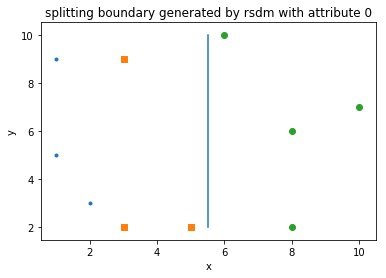

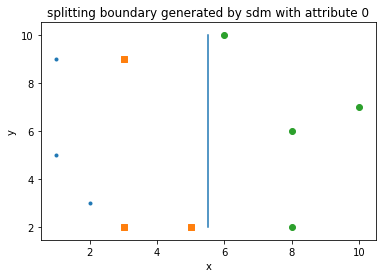

In [106]:
# rsdm 
f = Dsr(0)
g = Log()
h = Sum()

rsdm = Gdm(h, g, f)

# sdm
f = Ds(0)
g = Log()
h = Sum()

sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, training_set)
print("splitting value generated by rsdm on axis 0 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set)
print("splitting value generated by sdm on axis 0 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 0, "rsdm")
display_discretization(training_set, threshold_nr, 0, "sdm")

splitting value generated by rsdm on axis 1 :  5.5
corresponding entropy :  0.48838993179328605
splitting value generated by sdm on axis 1 :  2.5
corresponding entropy :  1.2896596952239763


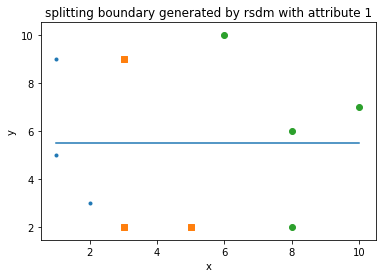

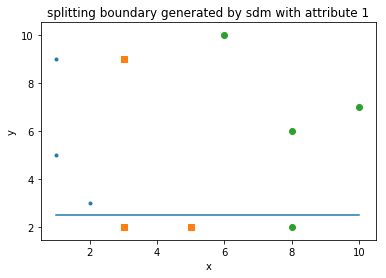

In [107]:
f = Dsr(1)
rsdm = Gdm(h, g, f)

f = Ds(1)
sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, training_set)
print("splitting value generated by rsdm on axis 1 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set)
print("splitting value generated by sdm on axis 1 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 1, "rsdm")
display_discretization(training_set, threshold_nr, 1, "sdm")

In [131]:
import random 
def generate_2Ddataset(a_j, k, n, noise, amplitude, ranges):
    '''
        a_j : monotone attribute
        k : number of labels
        n : number of examples to create 
        noise :  % of non-monotone noise
        amplitude : amplitude of noise
        ranges : array of arrays indicating, for each attribute, its min and max values
        generate a two-dimensional dataset with monotone attribute a_j
    '''
    labeled_set = LabeledSet(2)
    p = round(n/k)
    r = n # remaining examples to add 
    
    current_min = ranges[a_j][0]
    total_range = ranges[a_j][1] - ranges[a_j][0]
    
    for q in range(k):
        current_max = current_min + (total_range / k) 

        if (current_max > ranges[a_j][1]):
            current_max = ranges[a_j][1]
        
        if (current_max < ranges[a_j][1] and q == k-1):
            current_max = ranges[a_j][1] 
            
        print("class " + str(q+1) + " : [" + str(current_min) + " , " + str(current_max) + "]")
        
        if (p < r) and (q==k-1):
            p = r

        monotone_values = np.random.uniform(current_min, current_max, size=(p,1))
        
        if noise > 0:
            sample_size = np.random.binomial(len(monotone_values), noise)
            sample = np.random.randint(0, len(monotone_values), size=sample_size)
            
            for e in sample:
                if random.random() < 0.5:
                    monotone_values[e] = current_min - random.uniform(0, total_range * amplitude)
                else:
                    monotone_values[e] = current_max + random.uniform(0, total_range * amplitude)
            
        if (a_j == 0):
            random_values = np.random.uniform(ranges[1][0], ranges[1][1], size=(p, 1))
            values = np.hstack((monotone_values, random_values))
        else:
            random_values = np.random.uniform(ranges[0][0], ranges[0][1], size=(p,1))
            values = np.hstack((random_values, monotone_values))
        
        for i in range(p):
            labeled_set.addExample(values[i], q+1)
            
        current_min = current_max
        r -= p 
    return labeled_set

## Expérimentation sur des bases de données à deux dimensions

#### 2 classes : 

In [119]:
data_sets = []

data_sets.append(generate_2Ddataset(0, 2, 100, 0.0, 0.0, [[-10, 10], [-10, 10]])) # no noise
data_sets.append(generate_2Ddataset(0, 2, 100, 0.1, 0.1, [[-10, 10], [-10, 10]])) # a bit of noise, small amplitude
data_sets.append(generate_2Ddataset(0, 2, 100, 0.9, 0.1, [[-10, 10], [-10, 10]])) # lots of noise, small amplitude
data_sets.append(generate_2Ddataset(0, 2, 100, 0.1, 0.9, [[-10, 10], [-10, 10]])) # a bit of noise, large amplitude
data_sets.append(generate_2Ddataset(0, 2, 100, 0.9, 0.9, [[-10, 10], [-10, 10]])) # lots of noise, large amplitude
data_sets.append(generate_2Ddataset(0, 2, 100, 0.3, 0.3, [[-10, 10], [-10, 10]])) # medium amount of noise and medium amplitude

class 1 : [-10 , 0.0]
class 2 : [0.0 , 10.0]
class 1 : [-10 , 0.0]
class 2 : [0.0 , 10.0]
class 1 : [-10 , 0.0]
class 2 : [0.0 , 10.0]
class 1 : [-10 , 0.0]
class 2 : [0.0 , 10.0]
class 1 : [-10 , 0.0]
class 2 : [0.0 , 10.0]
class 1 : [-10 , 0.0]
class 2 : [0.0 , 10.0]


In [125]:
for data_set in data_sets:
    plot2DSet(data_set)

TypeError: 'LabeledSet' object is not callable

In [132]:
data_set = generate_2Ddataset(0, 2, 100, 0.0, 0.1, [[-10, 10], [-10, 10]])

plot2DSet(data_set)

class 1 : [-10 , 0.0]
class 2 : [0.0 , 10.0]


TypeError: 'LabeledSet' object is not callable

In [ ]:
f = Dsr(0)
rsdm = Gdm(h, g, f)

f = Ds(0)
sdm = Gdm(h, g, f)


In [ ]:
f = Dsr(0)
rsdm = Gdm(h, g, f)

f = Ds(0)
sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, data_set)
print("splitting value generated by rsdm on axis 0 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, data_set)
print("splitting value generated by sdm on axis 0 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(data_set, threshold_r, 0, "rsdm")
display_discretization(data_set, threshold_nr, 0, "sdm")

class 1 : [-10 , 0.0]
class 2 : [0.0 , 10.0]


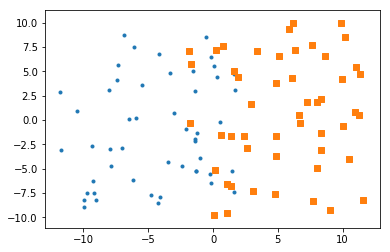

In [115]:
data_set = generate_2Ddataset(0, 2, 100, 0.3, 0.1, [[-10, 10], [-10, 10]])

plot2DSet(data_set)

splitting value generated by rsdm on axis 0 :  0.5780384101584914
corresponding entropy :  0.11523358811689799
splitting value generated by sdm on axis 0 :  -0.061075951176867704
corresponding entropy :  0.4604634265784404


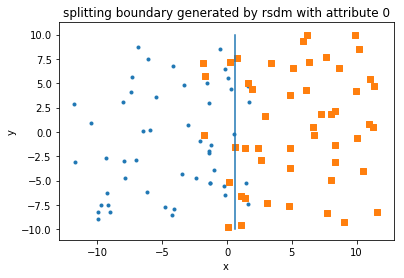

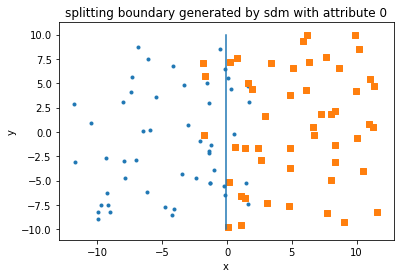

In [116]:
f = Dsr(0)
rsdm = Gdm(h, g, f)

f = Ds(0)
sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, data_set)
print("splitting value generated by rsdm on axis 0 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, data_set)
print("splitting value generated by sdm on axis 0 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(data_set, threshold_r, 0, "rsdm")
display_discretization(data_set, threshold_nr, 0, "sdm")